In [1]:
import numpy as np 
import time

import torch 
import torch.nn as nn
import torch.nn.functional as F 

import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler

from utils.inference import Trainer, plot_loss
from utils.models import DNN
import utils.datasets as d

In [4]:
X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [6]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
test = d.H_alphaSequences(X_test, y_test)

In [8]:
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size=10, shuffle=True)

In [18]:
# test_data,y_l = next(iter(test_loader))

# VAE

In [38]:
mod = torch.load("models_and_losses/DeepDenseVAE_mark_V_[160-256-128-15]_VDO_GNLL_400ep_lr-1e-4.pt")

In [39]:
mod

DeepDenseVAE_mark_V(
  (encoder): Sequential(
    (0): Linear(in_features=160, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): VariationalLayer(
      (mu): Linear(in_features=128, out_features=15, bias=True)
      (rho): Linear(in_features=128, out_features=15, bias=True)
      (softplus): Softplus(beta=1, threshold=20)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): VariationalDecoderOutput(
      (mu): Linear(in_features=256, out_features=160, bias=True)
      (rho): Linear(in_features=256, out_features=1, bias=True)
      (softplus): Softplus(beta=1, threshold=20)
    )
  )
)

In [40]:
test_data

tensor([[ 0.0527,  0.0771,  0.0859,  ...,  0.0040,  0.0698,  0.1100],
        [-0.5160, -0.5205, -0.5327,  ..., -0.5101, -0.5169, -0.5114],
        [-0.6378, -0.6510, -0.6540,  ..., -0.6337, -0.6430, -0.6324],
        ...,
        [ 0.4776,  0.5128,  0.5287,  ...,  0.4193,  0.4440,  0.5285],
        [ 1.4848,  1.4835,  1.4865,  ...,  1.4371,  1.5230,  1.5244],
        [-0.1601, -0.1604, -0.1899,  ..., -0.2821, -0.2414, -0.2352]])

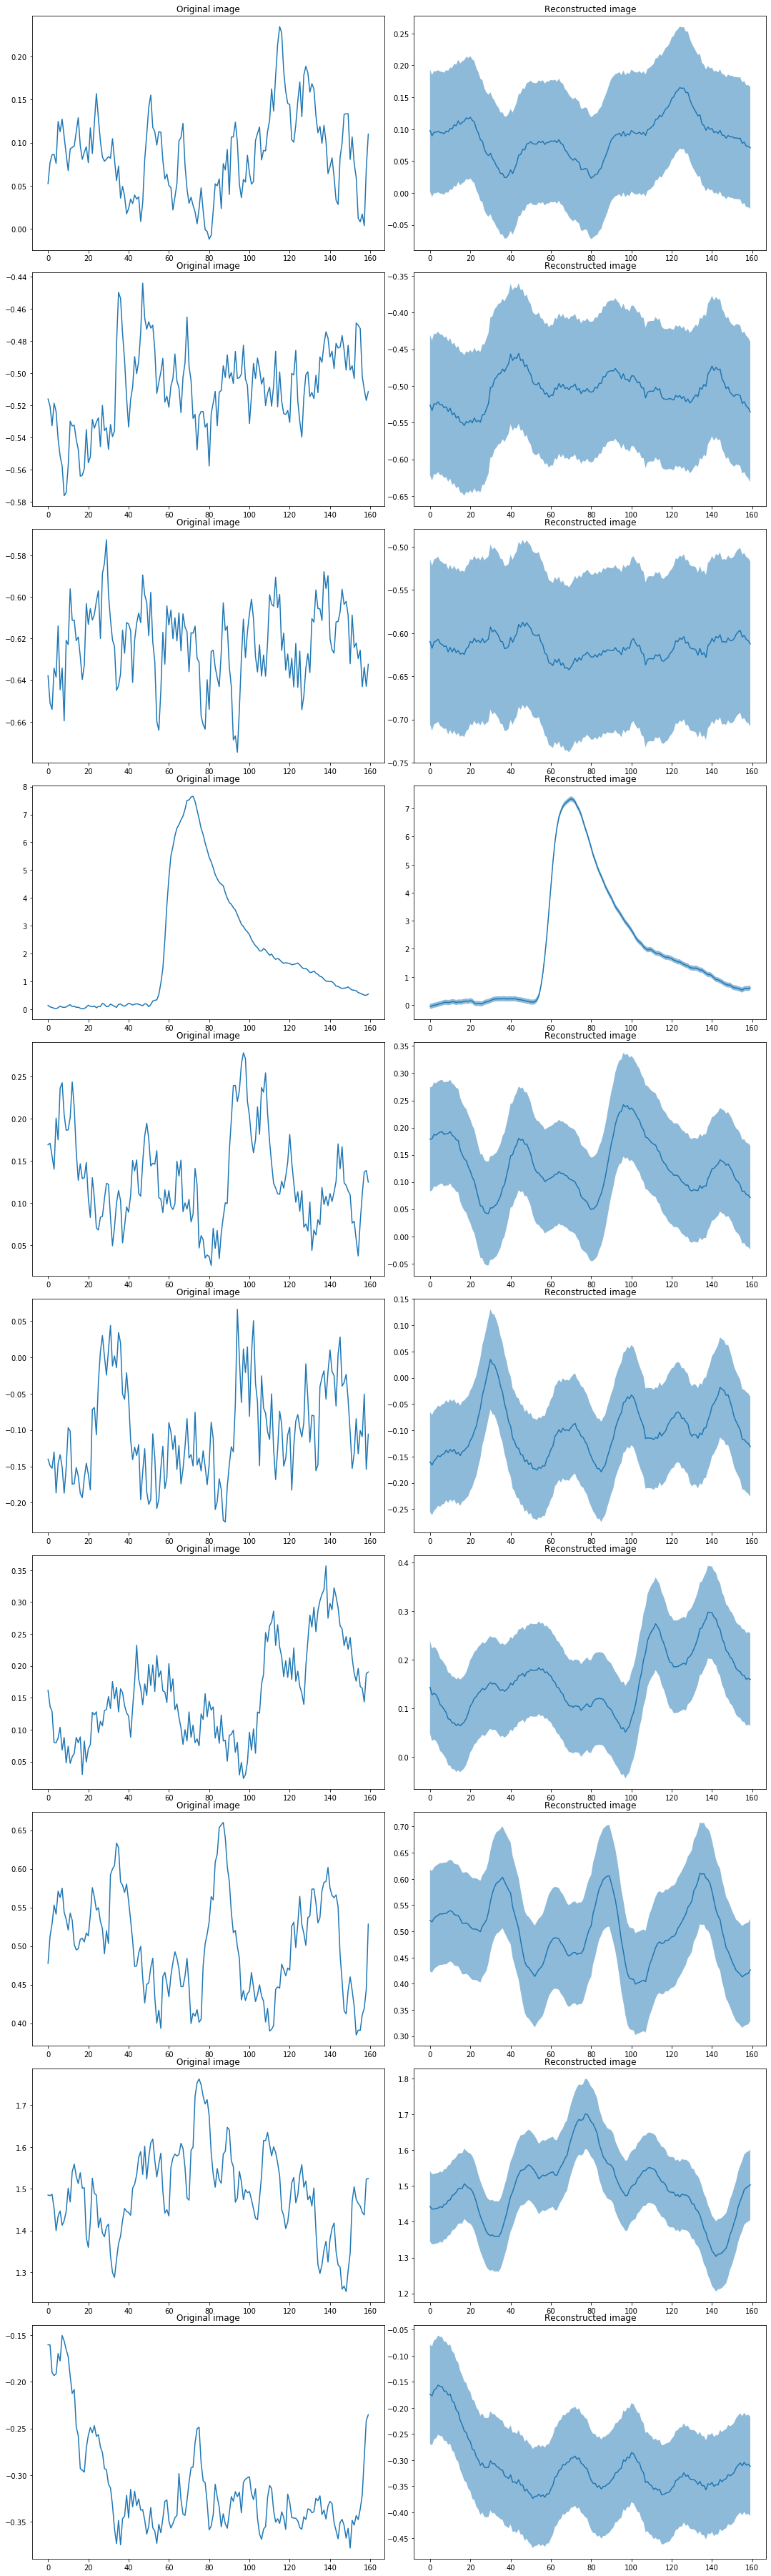

In [42]:
output1, mu1, sigma1 = mod(test_data.cuda())
#X_hat = output.cpu().detach().numpy()
mu_hat1 = output1[0].cpu().detach().numpy()
sigma1 = output1[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(test_data[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat1[i])
    axes[i][1].fill_between(np.arange(160), mu_hat1[i] + 2 * sigma1[i], mu_hat1[i] - 2 * sigma1[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

# CVAE

In [44]:
mod_CNN = torch.load("models_and_losses/CNN-VAE_ReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.pt")

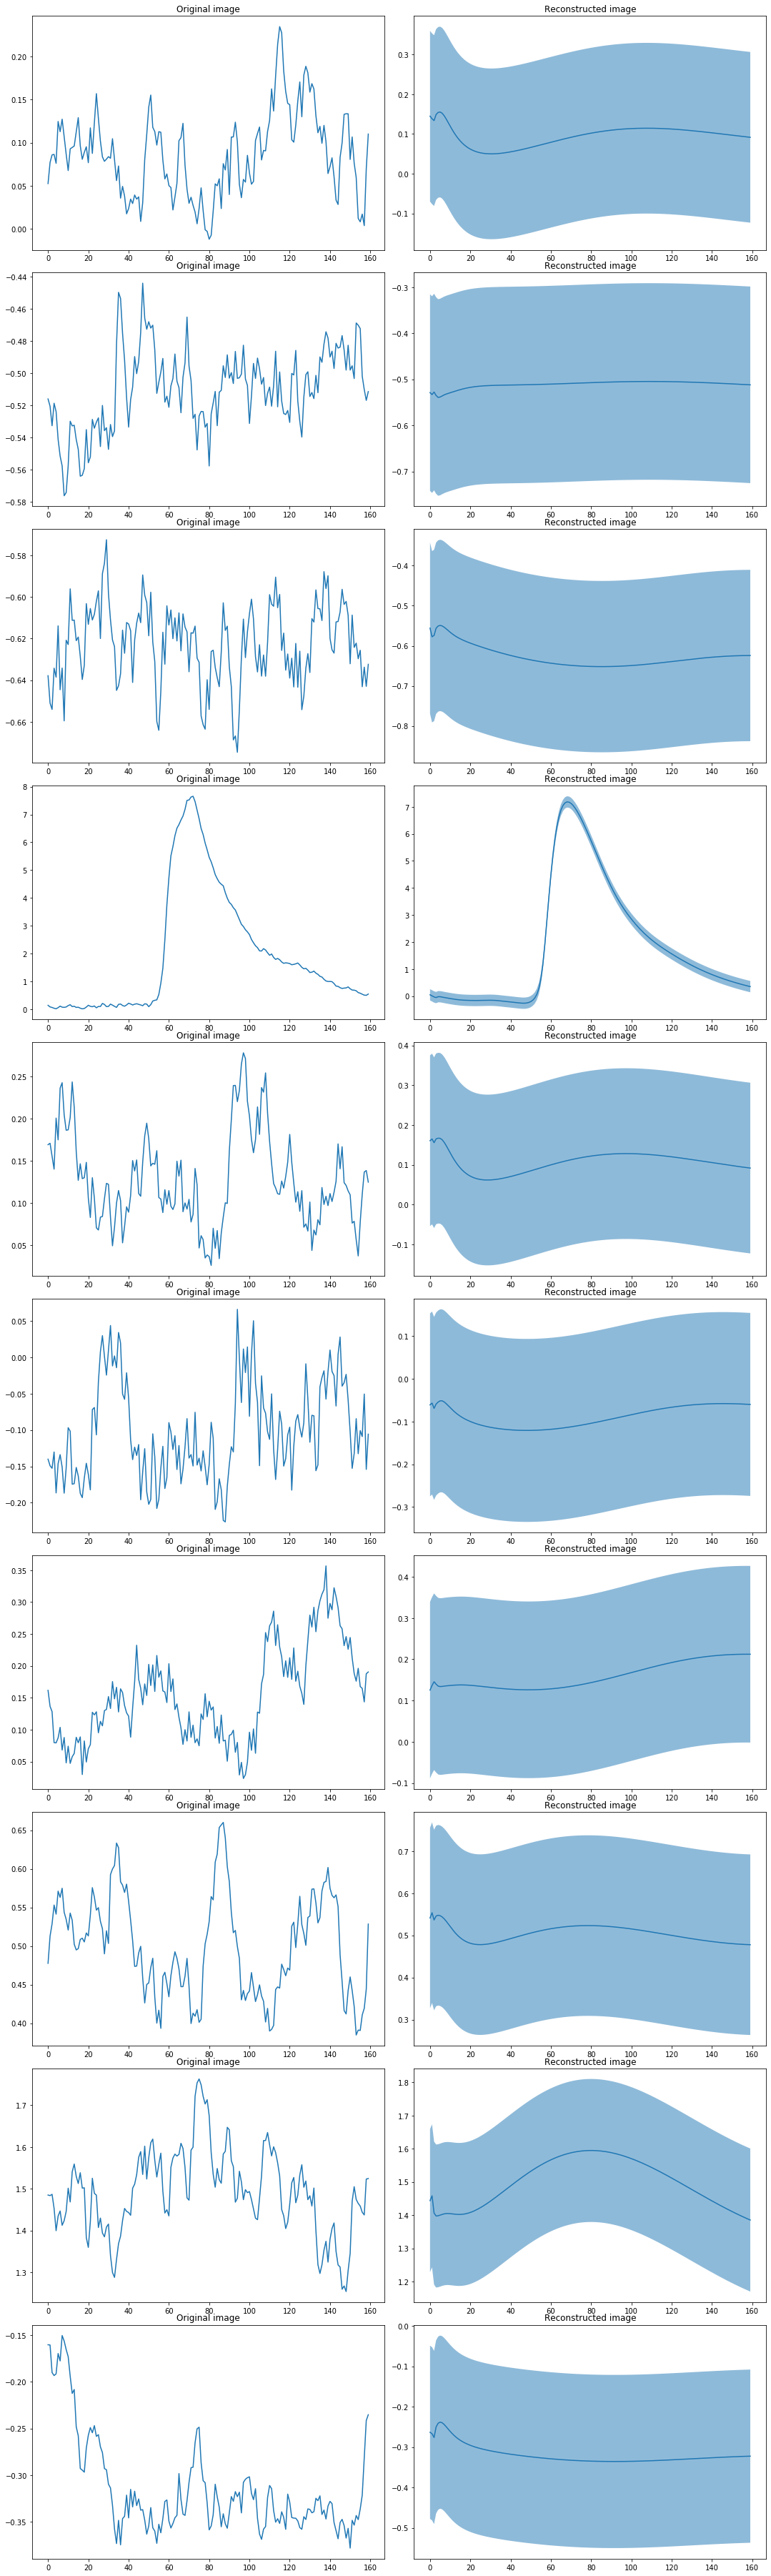

In [47]:
output2, mu, sigma2 = mod_CNN(test_data.cuda())
#X_hat = output.cpu().detach().numpy()
mu_hat2 = output2[0].cpu().detach().numpy()
sigma2 = output2[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(test_data[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

# LSTM VAE

In [25]:
mod_lstm = torch.load("models_and_losses/DeepLSTM_VAE_NLL_440ep_hidden-128_lr-{1e-3, 1e-4}_bs-300.pt")

In [27]:
t= []
for i in range(29):
    tt,_ = next(iter(test_loader))
    t.append(tt)

In [29]:
t.insert(0, test_data)

In [33]:
ttt = torch.cat(t, axis=0)

In [34]:
ttt.shape

torch.Size([300, 160])

In [36]:
o, m, s = mod_lstm(ttt.cuda())
output = o[0:10]
mu = m[0:10]
sigma = s[0:10]

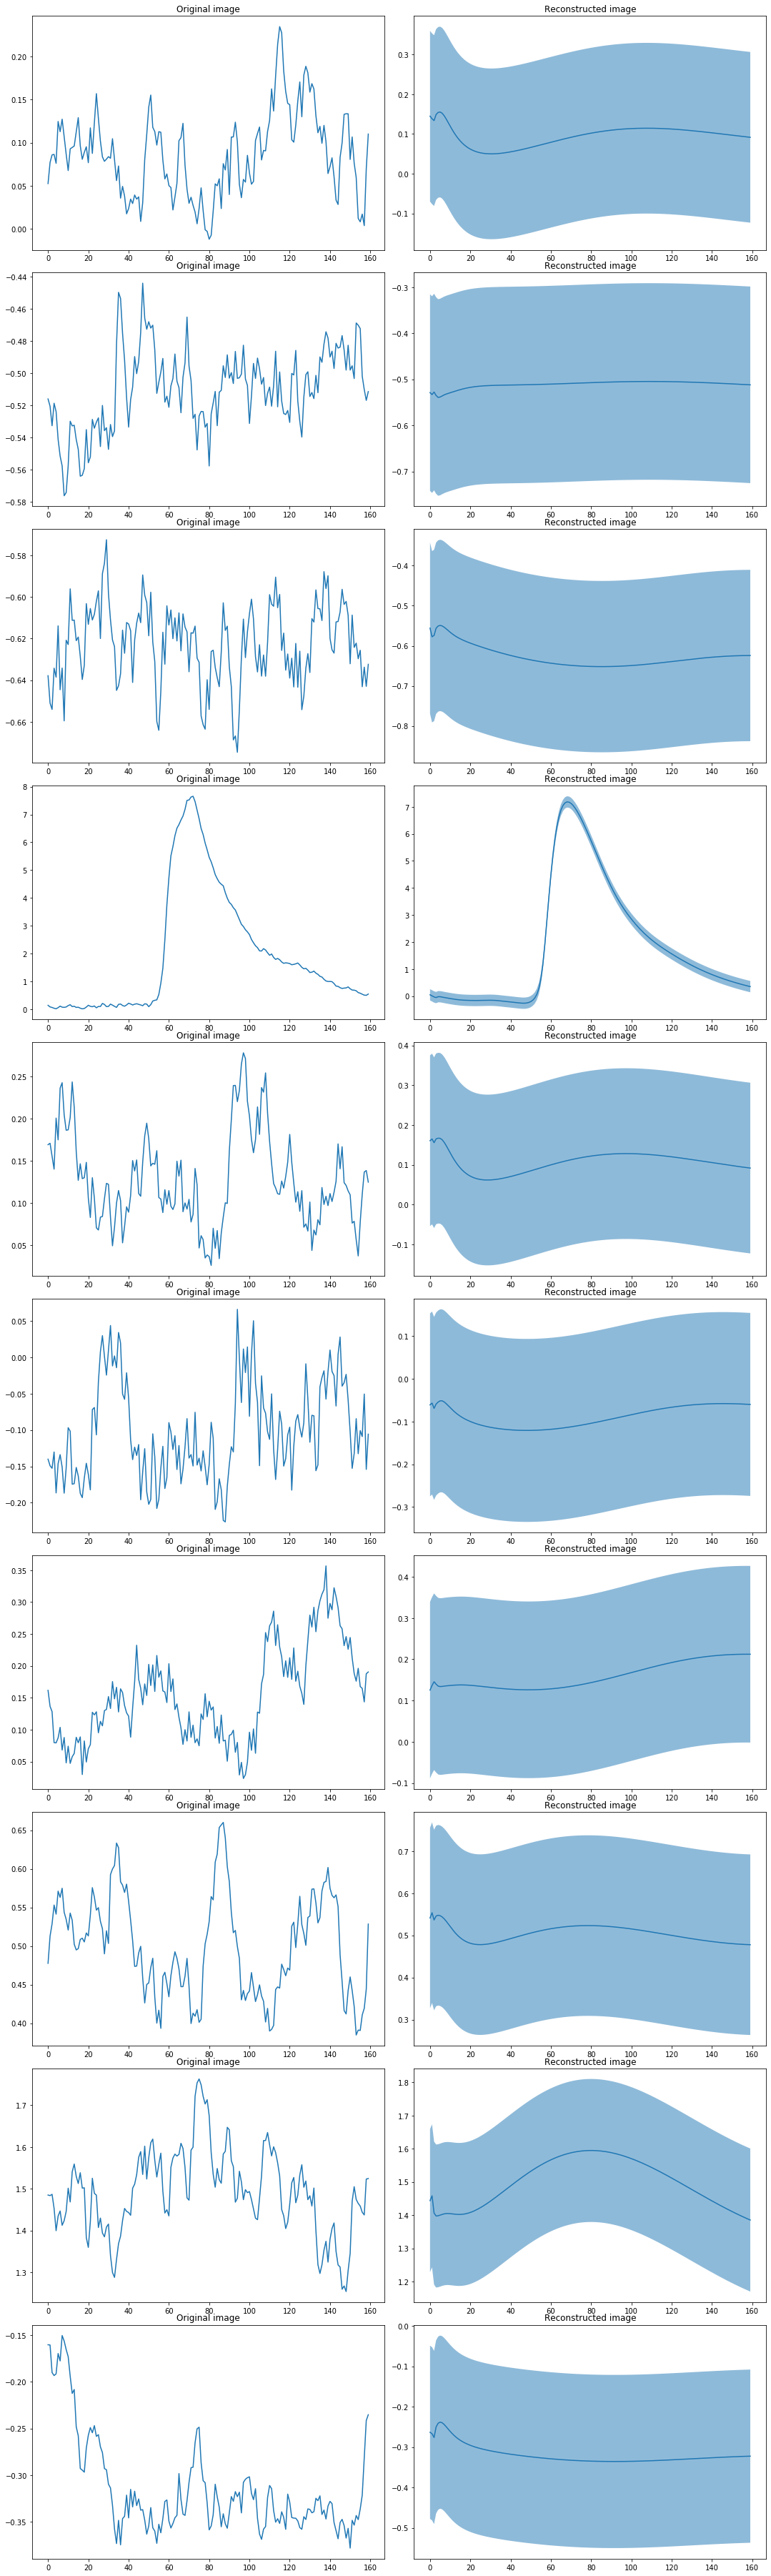

In [37]:
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(test_data[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

# Porovnání

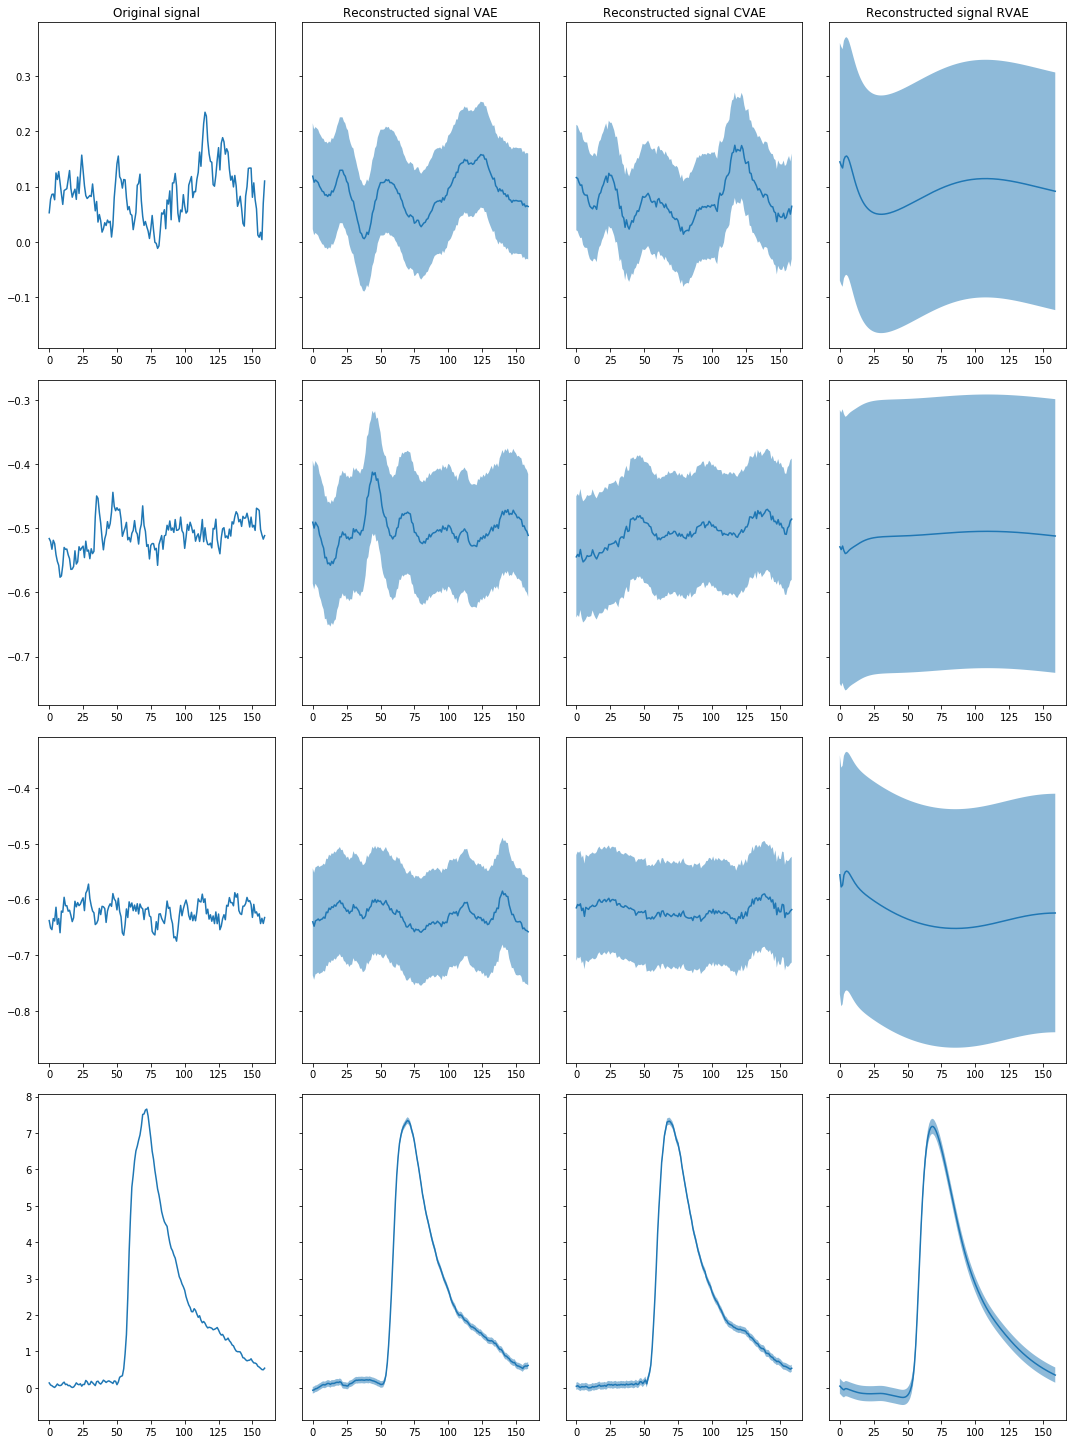

In [56]:
output1, mu1, sigma1 = mod(test_data.cuda())

mu_hat1 = output1[0].cpu().detach().numpy()
sigma1 = output1[1].cpu().detach().numpy()

output2, mu, sigma2 = mod_CNN(test_data.cuda())

mu_hat2 = output2[0].cpu().detach().numpy()
sigma2 = output2[1].cpu().detach().numpy()

fig, axes = plt.subplots(4, 4, figsize=(15,20), sharey="row")
fig.tight_layout()
for i in range(4):
    axes[i][0].plot(test_data[i])
    if i==0:
        axes[i][0].set_title('Original signal')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat1[i])
    axes[i][1].fill_between(np.arange(160), mu_hat1[i] + 2 * sigma1[i], mu_hat1[i] - 2 * sigma1[i], alpha = 0.5, label="Uncertainty")
    if i==0:
        axes[i][1].set_title('Reconstructed signal VAE') 
    axes[i][2].plot(mu_hat2[i])
    axes[i][2].fill_between(np.arange(160), mu_hat2[i] + 2 * sigma2[i], mu_hat2[i] - 2 * sigma2[i], alpha = 0.5, label="Uncertainty")
    if i==0:
        axes[i][2].set_title('Reconstructed signal CVAE')
    axes[i][3].plot(mu_hat[i])
    axes[i][3].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    if i==0:
        axes[i][3].set_title('Reconstructed signal RVAE')
        
plt.savefig('reconstruction_4.png', format='png')